In [56]:
from PIL import Image, ImageDraw
from pathlib import Path
import numpy as np
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import cv2

from Preprocessor.FaceExtractor import FaceExtractor
from Preprocessor.FaceReconstructor import FaceReconstructor
from configuration.run_config import current_config
from FaceAnonymizer.Anonymizer import Anonymizer

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# Print the location of each facial feature in this image
facial_features = [
    'chin',
    'left_eyebrow',
    'right_eyebrow',
    'nose_bridge',
    'nose_tip',
    'left_eye',
    'right_eye',
    'top_lip',
    'bottom_lip'
    ]

%env CUDA_VISIBLE_DEVICES=1

def list_landmarks(landmarks_dict):
    """
    Extracts the coordinates of the landmarks from the landmarks dictionary
    to a list of coordinates
    :param landmarks_dict: Dict of facial landmarks
    :return: List with tuples that represent the coordinates
    """
    # Extract coordinates from landmarks dict via list comprehension
    landmarks_list = [coordinate for feature in list(landmarks_dict.values())
                      for coordinate in feature]
    return landmarks_list


def dict_landmarks(landmarks_list):
    landmarks_dict = {}
    landmarks_dict['chin'] = landmarks_list[0:17]
    landmarks_dict['left_eyebrow'] = landmarks_list[17:22]
    landmarks_dict['right_eyebrow'] = landmarks_list[22:27]
    landmarks_dict['nose_bridge'] = landmarks_list[27:31]
    landmarks_dict['nose_tip'] = landmarks_list[31:36]
    landmarks_dict['left_eye'] = landmarks_list[36:42]
    landmarks_dict['right_eye'] = landmarks_list[42:48]
    landmarks_dict['top_lip'] = landmarks_list[48:60]
    landmarks_dict['bottom_lip'] = landmarks_list[60:72]
    return landmarks_dict

env: CUDA_VISIBLE_DEVICES=1


# Initialize components

In [2]:
config = current_config
face_extractor = FaceExtractor(margin=0.05,mask_type=np.bool,mask_factor=10)
face_reconstructor = FaceReconstructor(mask_factor=-15)

In [3]:
model_folder = Path('/nfs/students/summer-term-2018/project_2/models/celebA')
model = config['model']
model = model(config['img_size'])
model.load_model(model_folder)

Loading model... /nfs/students/summer-term-2018/project_2/models/celebA/decoder.model


In [4]:
image_path = Path('/nfs/students/summer-term-2018/project_2/test/220px-Louise_Mensch,_May_2015_(1).jpeg')
image = Image.open(image_path)

# Anonymizer with Landmarks + PixelMap

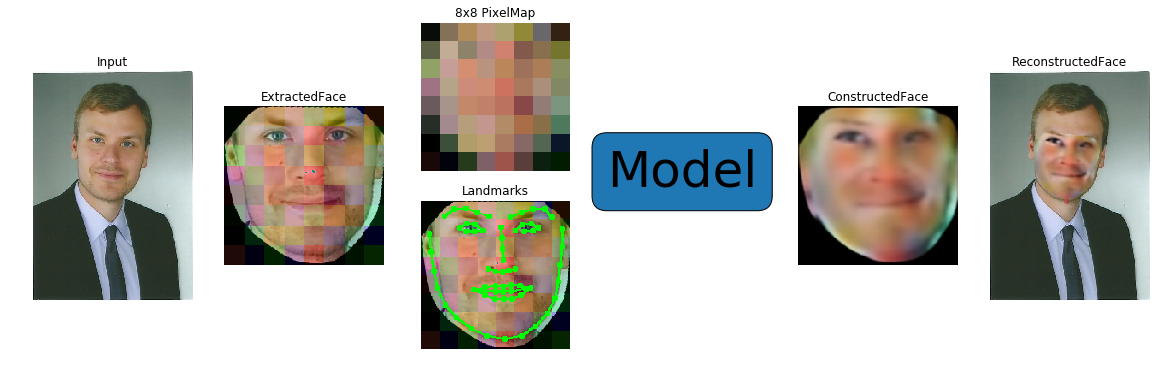

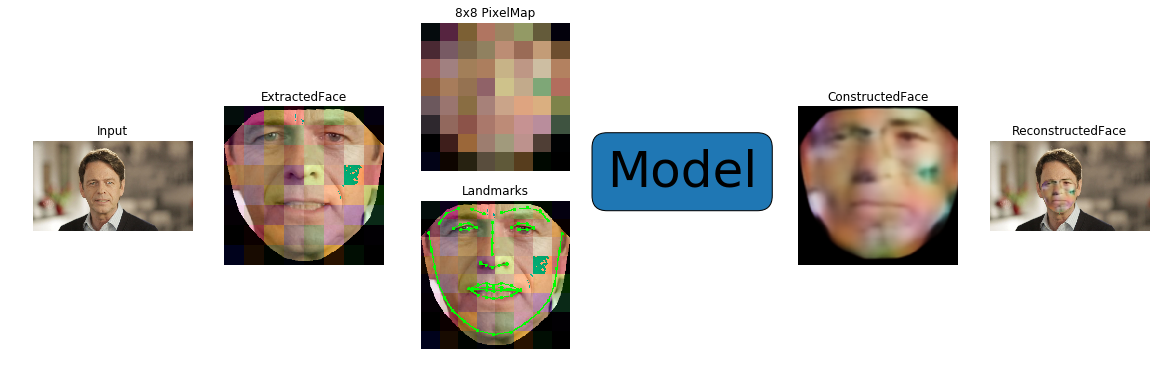

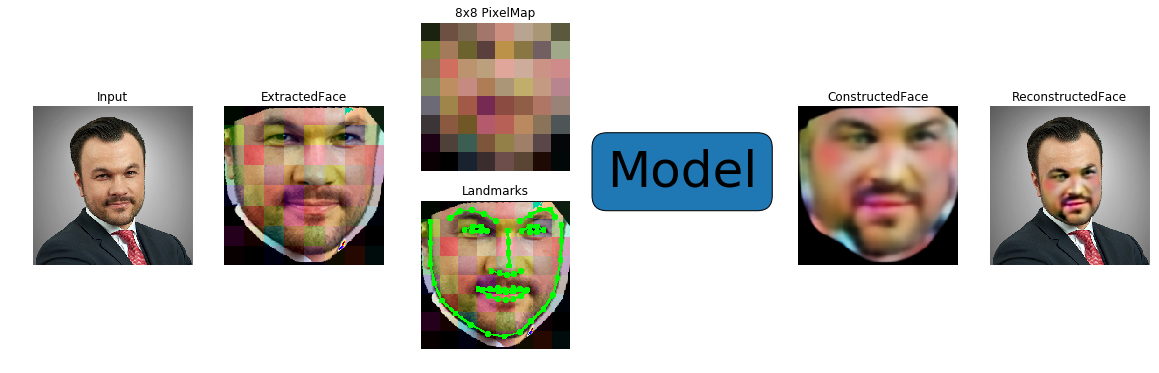

In [71]:
image_folder = Path('/nfs/students/summer-term-2018/project_2/test/')

for image_path in image_folder.iterdir():
    if image_path.is_dir():
        continue
    image = Image.open(image_path)
    # ====================== Anonymizer pipeline
    # === Extract face
    extracted_face, extracted_information = face_extractor(image)
    
    # ============ Completly random inputs
    # Random pixel map
    #extracted_face = Image.fromarray(np.random.randint(0,256,size=(8,8,3),dtype='uint8')).resize(extracted_face.size)
    # Random facial features
    #extracted_information.landmarks = np.random.random(size=(72,2))*extracted_information.size_fine
    # Remapping to tuple after manipulation
    #extracted_information.landmarks = list(map(tuple,extracted_information.landmarks))
    
    # ============ Additional gaussian noise
    # Random pixel map
    noise = 20*np.random.normal(size=(8,8,3))
    noise = cv2.resize(noise, dsize=extracted_face.size, interpolation=cv2.INTER_NEAREST)
    extracted_face = np.array(extracted_face) + noise
    extracted_face = np.clip(extracted_face, 0, 256).astype(np.uint8)
    extracted_face = Image.fromarray(extracted_face)
    # Random facial features
    #extracted_information.landmarks += 0.025*np.random.normal(size=(72,2))*extracted_information.size_fine
    # Remapping to tuple after manipulation
    #extracted_information.landmarks = list(map(tuple,extracted_information.landmarks))
    
    # Draw landmarks in extracted face
    landmarks_dict = dict_landmarks(extracted_information.landmarks)
    landmarks_face = extracted_face.copy()
    d = ImageDraw.Draw(landmarks_face)
    r = 3
    for facial_feature in facial_features:
        for x,y in landmarks_dict[facial_feature]:
            d.ellipse((x-r, y-r, x+r, y+r), fill=(0,255,0))
        d.line(landmarks_dict[facial_feature], width = r, fill=(0,255,0))

    
    # Create low res 8x8 pixel map
    low_res = extracted_face.resize((8, 8), Image.BICUBIC)
    
    # === Neural network
    latent_information = config['img2latent_bridge'](extracted_face, extracted_information,config['img_size'])
    # feed into network
    face_out = model.anonymize(latent_information).squeeze(0)
    face_out = ToPILImage()(face_out.cpu().detach())
    # scale to original resolution
    face_out = face_out.resize(extracted_face.size, resample=Image.BICUBIC)
    
    # === Reconstruct face
    reconstructed_face = face_reconstructor(face_out, extracted_information)
    
    # ====================== Plot
    fig = plt.figure(figsize=(20,6))
    plt.subplot(1,6,1)
    plt.imshow(extracted_information.image_original)
    plt.title('Input')
    plt.axis('off')
    
    plt.subplot(1,6,2)
    plt.imshow(extracted_face)
    plt.title('ExtractedFace')
    plt.axis('off')
    
    plt.subplot(2,6,3)
    plt.imshow(low_res)
    plt.title('8x8 PixelMap')
    plt.axis('off')
    
    plt.subplot(2,6,9)
    plt.imshow(landmarks_face)
    plt.title('Landmarks')
    plt.axis('off')
    
    plt.subplot(1,6,4)
    plt.text(0,0.5,'Model', size=50, bbox=dict(boxstyle="round"))
    plt.axis('off')
    
    plt.subplot(1,6,5)
    plt.imshow(face_out)
    plt.title('ConstructedFace')
    plt.axis('off')
    
    plt.subplot(1,6,6)
    plt.imshow(reconstructed_face)
    plt.title('ReconstructedFace')
    plt.axis('off')
    
    plt.show()

# Anonymizer with Landmarks and PixelMap - SwappedLandmarks

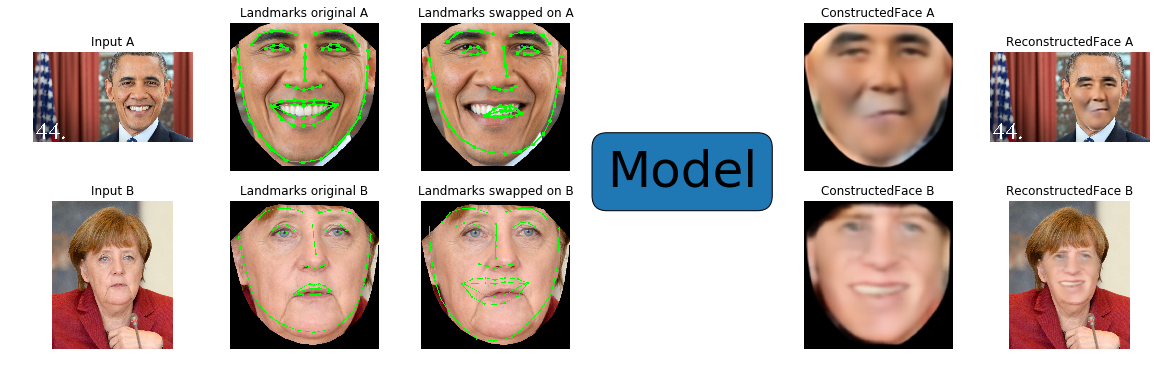

In [85]:
image_path_A = Path('/nfs/students/summer-term-2018/project_2/test/44_barack_obama1.jpg')
image_path_B = Path('/nfs/students/summer-term-2018/project_2/test/111. angela_merkel_2016.jpg')


image_A = Image.open(image_path_A)
image_B = Image.open(image_path_B)
# ====================== Anonymizer pipeline
# === Extract face
extracted_face_A, extracted_information_A = face_extractor(image_A)
extracted_face_B, extracted_information_B = face_extractor(image_B)

# === Draw landmarks in extracted face
landmarks_dict_A = dict_landmarks(extracted_information_A.landmarks)
landmarks_face_A = extracted_face_A.copy()
d = ImageDraw.Draw(landmarks_face_A)
r = 3
for facial_feature in facial_features:
    for x,y in landmarks_dict_A[facial_feature]:
        d.ellipse((x-r, y-r, x+r, y+r), fill=(0,255,0))
    d.line(landmarks_dict_A[facial_feature], width = r, fill=(0,255,0))


landmarks_dict_B = dict_landmarks(extracted_information_B.landmarks)
landmarks_face_B = extracted_face_B.copy()
d = ImageDraw.Draw(landmarks_face_B)
r = 3
for facial_feature in facial_features:
    for x,y in landmarks_dict_B[facial_feature]:
        d.ellipse((x-r, y-r, x+r, y+r), fill=(0,255,0))
    d.line(landmarks_dict_B[facial_feature], width = r, fill=(0,255,0))

# =============== Swap landmarks
landmarks_A = np.array(extracted_information_A.landmarks) / extracted_information_A.size_fine
landmarks_B = np.array(extracted_information_B.landmarks) / extracted_information_B.size_fine

extracted_information_A.landmarks = landmarks_B * extracted_information_A.size_fine
extracted_information_B.landmarks = landmarks_A * extracted_information_B.size_fine

extracted_information_A.landmarks = list(map(tuple,extracted_information_A.landmarks))
extracted_information_B.landmarks = list(map(tuple,extracted_information_B.landmarks))

# === Draw swapped landmarks in extracted face
landmarks_dict_A = dict_landmarks(extracted_information_A.landmarks)
landmarks_swapped_A = extracted_face_A.copy()
d = ImageDraw.Draw(landmarks_swapped_A)
r = 3
for facial_feature in facial_features:
    for x,y in landmarks_dict_A[facial_feature]:
        d.ellipse((x-r, y-r, x+r, y+r), fill=(0,255,0))
    d.line(landmarks_dict_A[facial_feature], width = r, fill=(0,255,0))


landmarks_dict_B = dict_landmarks(extracted_information_B.landmarks)
landmarks_swapped_B = extracted_face_B.copy()
d = ImageDraw.Draw(landmarks_swapped_B)
r = 3
for facial_feature in facial_features:
    for x,y in landmarks_dict_B[facial_feature]:
        d.ellipse((x-r, y-r, x+r, y+r), fill=(0,255,0))
    d.line(landmarks_dict_B[facial_feature], width = r, fill=(0,255,0))


# === Neural network
latent_information_A = config['img2latent_bridge'](extracted_face_A, extracted_information_A,config['img_size'])
# feed into network
face_out_A = model.anonymize(latent_information_A).squeeze(0)
face_out_A = ToPILImage()(face_out_A.cpu().detach())
# scale to original resolution
face_out_A = face_out_A.resize(extracted_face_A.size, resample=Image.BICUBIC)

latent_information_B = config['img2latent_bridge'](extracted_face_B, extracted_information_B,config['img_size'])
# feed into network
face_out_B = model.anonymize(latent_information_B).squeeze(0)
face_out_B = ToPILImage()(face_out_B.cpu().detach())
# scale to original resolution
face_out_B = face_out_B.resize(extracted_face_B.size, resample=Image.BICUBIC)

# === Reconstruct face
reconstructed_face_A = face_reconstructor(face_out_A, extracted_information_A)
reconstructed_face_B = face_reconstructor(face_out_B, extracted_information_B)

# ====================== Plot
fig = plt.figure(figsize=(20,6))
plt.subplot(2,6,1)
# Inputs
plt.imshow(extracted_information_A.image_original)
plt.title('Input A')
plt.axis('off')

plt.subplot(2,6,7)
plt.imshow(extracted_information_B.image_original)
plt.title('Input B')
plt.axis('off')

# Landmarks
plt.subplot(2,6,2)
plt.imshow(landmarks_face_A)
plt.title('Landmarks original A')
plt.axis('off')

plt.subplot(2,6,8)
plt.imshow(landmarks_face_B)
plt.title('Landmarks original B')
plt.axis('off')

# Landmarks swapped
plt.subplot(2,6,3)
plt.imshow(landmarks_swapped_A)
plt.title('Landmarks swapped on A')
plt.axis('off')

plt.subplot(2,6,9)
plt.imshow(landmarks_swapped_B)
plt.title('Landmarks swapped on B')
plt.axis('off')

# Model Box
plt.subplot(1,6,4)
plt.text(0,0.5,'Model', size=50, bbox=dict(boxstyle="round"))
plt.axis('off')

# Constructed
plt.subplot(2,6,5)
plt.imshow(face_out_A)
plt.title('ConstructedFace A')
plt.axis('off')

plt.subplot(2,6,11)
plt.imshow(face_out_B)
plt.title('ConstructedFace B')
plt.axis('off')


# Reconstructed
plt.subplot(2,6,6)
plt.imshow(reconstructed_face_A)
plt.title('ReconstructedFace A')
plt.axis('off')

plt.subplot(2,6,12)
plt.imshow(reconstructed_face_B)
plt.title('ReconstructedFace B')
plt.axis('off')

plt.show()